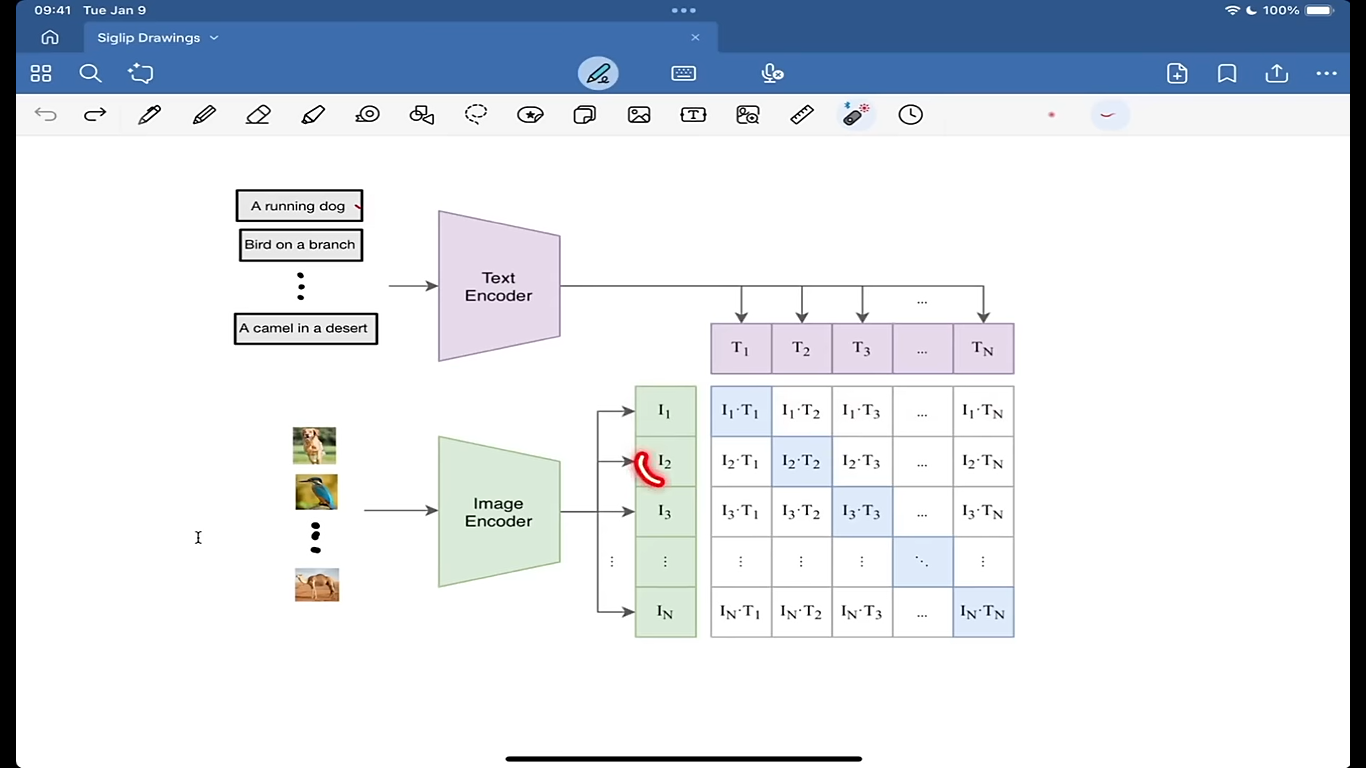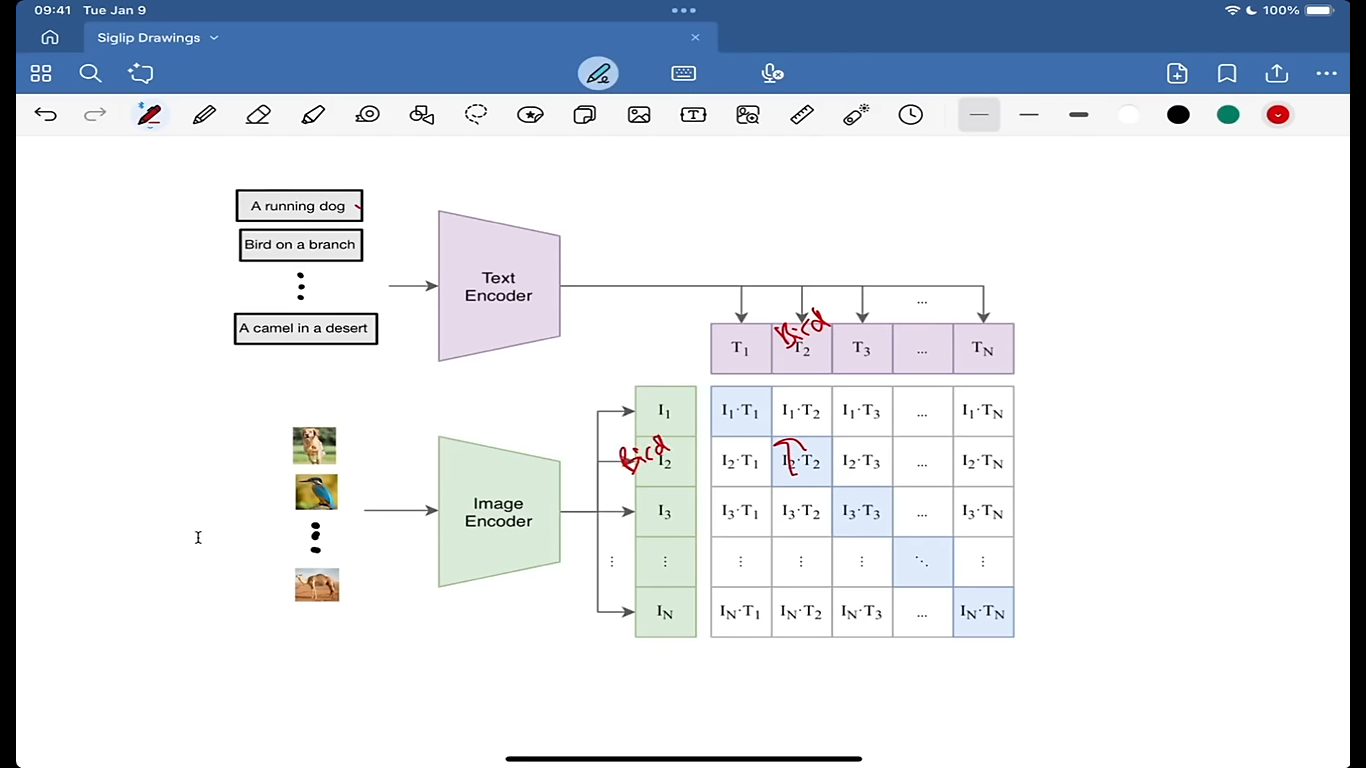

In [1]:
from transformers import AutoProcessor, SiglipVisionModel, SiglipVisionConfig #AutoProcessor is like autotokenizer in nlp and Sigli.. is like BertModel

processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")
vision_model = SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224", config=SiglipVisionConfig(vision_use_head=False))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

In [2]:
vision_model

SiglipVisionModel(
  (vision_model): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(196, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attn): SiglipAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, 

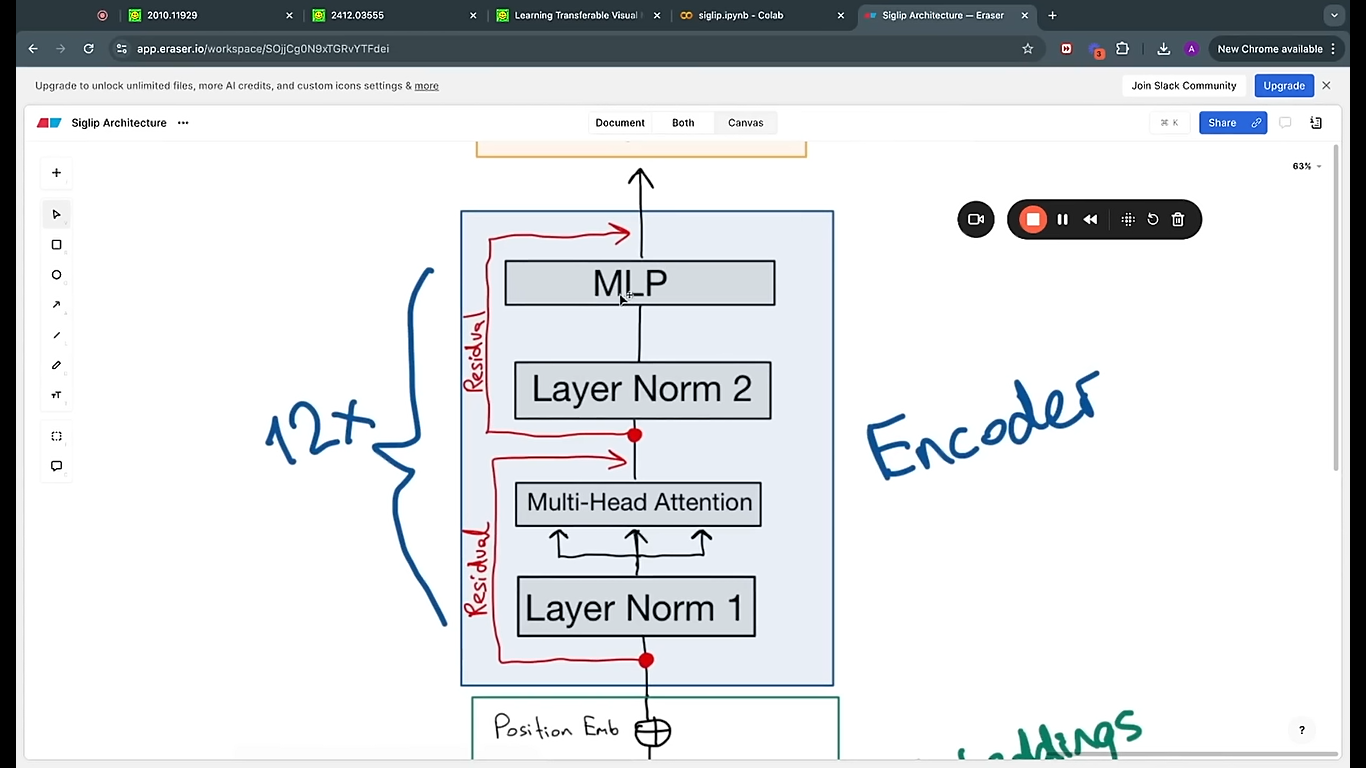

In [3]:
import numpy as np
import torch
import torch.nn as nn
import math
from torch.nn import functional as F

In [4]:
class Embedding(nn.Module):

  def __init__(self, config):
    super().__init__()

    self.num_channels = config.num_channels
    self.emb_dim = config.emb_dim
    self.cls_token = nn.Parameter(torch.zeros(1,1,config.emb_dim))
    self.image_size = config.img_size
    self.patch_size = config.patch_size

    self.patch_embedding = nn.Conv2d(in_channels  = self.num_channels, out_channels=self.emb_dim, kernel_size = self.patch_size, stride=self.patch_size, padding = "valid")

    self.num_patches = (self.image_size // self.patch_size) ** 2
    self.num_positions = self.num_patches + 1

    self.position_embedding = nn.Embedding(self.num_positions, self.emb_dim)
    self.register_buffer("position_ids", torch.arange(self.num_positions + 1).expand((1,-1)), persistent=False)  # +1 is for CLS Token.


  def forward(self, pixel_values: torch.FloatTensor):

    B, C, H, W = pixel_values.shape   # e.g. [1, 3, 224, 224]

    # 1. Patch Embedding
    patch_embeds = self.patch_embedding(pixel_values)       # [B, 768, 14, 14]
    patch_embeds = patch_embeds.flatten(2).transpose(1, 2)  # [B, 196, 768]

    # 2. Add CLS token
    cls_token = self.cls_token.expand(B, -1, -1)             # [B, 1, 768]
    embeddings = torch.cat((cls_token, patch_embeds), dim=1)  # [B, 197, 768]

    # 3. Add positional embeddings
    embeddings = embeddings + self.position_embedding(self.position_ids[:, :embeddings.size(1)])

    return embeddings  # Final shape: [B, 197, 768]

In [5]:
class AttentionsHead(nn.Module):

  def __init__(self, config):

    super().__init__()
    self.n_heads = config.num_attention_heads
    self.embed_dim = config.hidden_size
    self.dropout = config.attention_dropout

    self.q_mat = nn.Linear(self.embed_dim, self.embed_dim)
    self.k_mat = nn.Linear(self.embed_dim, self.embed_dim)
    self.v_mat = nn.Linear(self.embed_dim, self.embed_dim)
    self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

  def forward(self, hidden_states):

    # hidden states are the embeddings of the patches of dim: [1, 196, 768]

    B, T, C = hidden_states.shape
    q_states = self.q_mat(hidden_states)
    k_states = self.k_mat(hidden_states)
    v_states = self.v_mat(hidden_states)

   # print(f"Shape of Q,K, V is: {q_states.shape}")

    q_states = q_states.view(B, T, self.n_heads, C // self.n_heads).transpose(1,2)
    k_states = k_states.view(B, T, self.n_heads, C // self.n_heads).transpose(1,2)
    v_states = v_states.view(B, T, self.n_heads, C // self.n_heads).transpose(1,2)

   # print(f"Shape of Q,K, V is: {q_states.shape}")

    attn_weights = (q_states @ k_states.transpose(-2, -1)) * (1.0 / math.sqrt(k_states.size(-1)))

   # print(f"Shape of attention score is: {attn_weights.shape}")

    attn_weights = F.softmax(attn_weights, dim = -1).to(q_states.dtype)
    attn_weights = F.dropout(attn_weights, p = self.dropout, training=self.training)

    attn_outs = attn_weights @ v_states

   # print(f"Shape of attention score is: {attn_outs.shape}")
    attn_outs = attn_outs.transpose(1,2)
   # print(f"Shape of attention score is: {attn_outs.shape}")
    print()

    attn_outs = attn_outs.reshape(B, T, C).contiguous()
    attn_outs = self.out_proj(attn_outs)
    return attn_outs

In [6]:
class FFNN(nn.Module):

  def __init__(self, config):
    super().__init__()

    self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
    self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)

  def forward(self, hidden_states: torch.Tensor):

    hidden_states = self.fc1(hidden_states)
    hidden_states = F.gelu(hidden_states, approximate = 'tanh')
    hidden_states = self.fc2(hidden_states)
    return hidden_states

#**ENCODER**

In [7]:
class Encoder(nn.Module):

  def __init__(self, config):
    super().__init__()

    self.config = config
    self.attentionHead = AttentionsHead(config)
    self.layer_norm1 = nn.LayerNorm(config.emb_dim, eps = config.layer_norm_eps)
    self.layer_norm2 = nn.LayerNorm(config.emb_dim, eps = config.layer_norm_eps)
    self.ffnn = FFNN(config)


  def forward(self, embeddings):

    residual = embeddings
    embeddings = self.layer_norm1(embeddings)
    embeddings = self.attentionHead(embeddings)
    embeddings = residual + embeddings

    print(f"First Part Worked!")

    residual = embeddings
    embeddings = self.layer_norm2(embeddings)
    embeddings = self.ffnn(embeddings)
    embeddings = embeddings + residual

    print(f"Second Part Worked!")

    return embeddings

In [8]:
class SingLipEncoder(nn.ModuleList):

  def __init__(self, config):
    super().__init__()
    self.embeddings = Embedding(config=config)
    self.layers = nn.ModuleList(Encoder(config=config) for _ in range(12))

  def forward(self, embeddings):
    for layer in self.layers:
      output = layer(embeddings)
    return output

In [9]:
class ConfigParams:

  num_channels: int = 3
  emb_dim : int = 768
  img_size : int = 224
  patch_size : int = 16
  hidden_size = 768
  intermediate_size = 3072
  num_attention_heads: int = 12
  hidden_size: int = 768
  layer_norm_eps : float = 1e-6
  attention_dropout: float = 0.0
  epochs = 10
  total_classification: int = 10  #THIS IS FOR HOW MANY CLASSES WE HAVE... HE WILL PUT IT HERE.

config = ConfigParams()

In [10]:
class SingLipTransformer(nn.Module):

  def __init__(self, config):
    super().__init__()
    self.embedding = Embedding(config=config)
    self.all_layers = SingLipEncoder(config=config)
    self.post_layernorm = nn.LayerNorm(config.emb_dim, eps=config.layer_norm_eps)
    self.classify_head = nn.Linear(config.emb_dim, config.total_classification)

  def forward(self, image_tensor):

    embeddings = self.embedding(image_tensor)
    ffnn_outputs = self.all_layers(embeddings)
    normalised_outputs = self.post_layernorm(ffnn_outputs)

    #Extractting CLS tokens only:
    cls = normalised_outputs[:, 0, :]
    logits = self.classify_head(cls)

    return logits

In [11]:
Model = SingLipTransformer(config=config)

In [12]:
#output = Model(torch.randn(1, 3, 224, 224))

In [13]:
#output

In [14]:
# outputs is like: [[cls],[patch1], [patch2]..., [patch-n]]

#**DATA STUFFS**

In [15]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Resize to 224x224 for ViT
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])

train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data  = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=32)

100%|██████████| 170M/170M [00:18<00:00, 9.21MB/s]


#**TRAINING LOOP**

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(Model.parameters(), lr = 3e-4, weight_decay = 0.01)

In [17]:
device = "cuda"

Model = Model.to(device)

In [ ]:
for epoch in range(config.epochs):

  Model.train()
  total_loss = 0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    print("→ labels dtype:", labels.dtype)       # should be torch.int64
    print("→ labels shape:", labels.shape)       # should be [batch_size]
    print("→ labels device:", labels.device)     # should match model/device (usually cuda)


    optimizer.zero_grad()

    outputs = Model(images)

    print("→ outputs shape:", outputs.shape)  # should be [32, 10]
    assert outputs.shape == (labels.shape[0], 10), "❌ Output shape mismatch"

    print("→ outputs[0]:", outputs[0])  # just to see values

    loss = criterion(outputs, labels)

    loss.backward()

    optimizer.step()

    total_loss = total_loss + loss.item()

  print(f"Epoch: {epoch+1}. Loss: {total_loss/len(train_loader):.2f}")

Streaming output truncated to the last 5000 lines.
→ outputs[0]: tensor([-0.1383,  5.3747, -0.0214, -1.6265, -1.4889, -2.9674,  0.2307, -3.3715,
        -1.8250,  5.0674], device='cuda:0', grad_fn=<SelectBackward0>)
→ labels dtype: torch.int64
→ labels shape: torch.Size([32])
→ labels device: cuda:0

First Part Worked!
Second Part Worked!

First Part Worked!
Second Part Worked!

First Part Worked!
Second Part Worked!

First Part Worked!
Second Part Worked!

First Part Worked!
Second Part Worked!

First Part Worked!
Second Part Worked!

First Part Worked!
Second Part Worked!

First Part Worked!
Second Part Worked!

First Part Worked!
Second Part Worked!

First Part Worked!
Second Part Worked!

First Part Worked!
Second Part Worked!

First Part Worked!
Second Part Worked!
→ outputs shape: torch.Size([32, 10])
→ outputs[0]: tensor([-0.8556,  0.8088,  1.0363, -2.0047, -0.0498, -0.3630, -1.8408,  1.2654,
        -2.0896,  0.7638], device='cuda:0', grad_fn=<SelectBackward0>)
→ labels dtype: 